# Ingredient Normalization Evaluation

in this Notebook we evaluate the Normalization Pipeline to normalize the ingredients

In [4]:
from collections import defaultdict
import random
from foodrec.utils.data_preperation.embedder import Embedder
from operator import itemgetter
from tqdm import tqdm
from foodrec.data.load_ingredient_embeddings import EmbeddingLoader
from typing import Any, Dict, List, Sequence, Tuple
import math

from foodrec.config.structure.dataset_enum import DatasetEnum
from foodrec.tools.ingredient_normalizer import IngredientNormalisation

## Helper Methods

In [5]:
def introduce_typo(word: str) -> str:
    """Introduce character swap typo"""
    if len(word) < 4:
        return word
    i = random.randint(0, len(word) - 2)
    return word[:i] + word[i+1] + word[i] + word[i+2:]

def drop_random_char(word: str) -> str:
    """Drop a random character"""
    if len(word) < 4:
        return word
    i = random.randint(0, len(word) - 1)
    return word[:i] + word[i+1:]

def add_random_char(word: str) -> str:
    """Add a random character"""
    if len(word) < 3:
        return word
    chars = 'abcdefghijklmnopqrstuvwxyz'
    i = random.randint(0, len(word))
    return word[:i] + random.choice(chars) + word[i:]

def substitute_char(word: str) -> str:
    """Substitute a random character"""
    if len(word) < 3:
        return word
    chars = 'abcdefghijklmnopqrstuvwxyz'
    i = random.randint(0, len(word) - 1)
    return word[:i] + random.choice(chars) + word[i+1:]


### Create Testset

In [6]:
evaluation_categories = ['introduce_typo', 'drop_random_char', 'add_random_char', 'substitute_char']
def create_test_set(ls_ingredients):
    introduce_typo_ls = []
    drop_random_char_ls = []
    add_random_char_ls = []
    substitute_char_ls = []
    for ingredient in ls_ingredients:
        introduce_typo_ls.append([ingredient, introduce_typo(ingredient)])
        drop_random_char_ls.append([ingredient, drop_random_char(ingredient)])
        add_random_char_ls.append([ingredient, add_random_char(ingredient)])
        substitute_char_ls.append([ingredient, substitute_char(ingredient)])
    return {
        'introduce_typo':introduce_typo_ls,
        'drop_random_char': drop_random_char_ls,
        'add_random_char': add_random_char_ls,
        'substitute_char': substitute_char_ls
    }

### Evaluator

In [7]:
def _to_float(x: Any) -> float:
    """Sicher zu float konvertieren; None/NaN -> -inf."""
    try:
        v = float(x)
        return float("-inf") if math.isnan(v) else v
    except Exception:
        return float("-inf")

def _is_score(x: Any) -> bool:
    try:
        _ = float(x)
        return True
    except Exception:
        return False

def _is_record(x: Any, index: int) -> bool:
    # Echte Treffer sehen aus wie ['name', score1, ...]
    return (
        isinstance(x, (list, tuple))
        and len(x) > index
        and isinstance(x[0], str)          # Name vorhanden
        and _is_score(x[index])             # Score konvertierbar
    )

def calculate_best_match(index: int, res, ground_truth: str) -> Tuple[Any, float, bool]:
    if not res:
        return (None, None, False)

    # Wenn res bereits EIN Record ist, nimm ihn; sonst filtere echte Records aus der Liste
    candidates: List[Sequence[Any]] = [res] if _is_record(res, index) else [r for r in res if _is_record(r, index)]
    if not candidates:
        return (None, None, False)

    # Bestes Element nach Score
    best = max(candidates, key=lambda r: _to_float(r[index]))
    best_score = _to_float(best[index])

    name = best[0]
    ok = name.lower() == str(ground_truth).lower()
    return name, best_score, ok


In [ ]:
def evaluator(dataset_test) -> Dict[str, Dict[str, List[Tuple[Sequence[Any], Any, bool]]]]:
    ingredient_normalizer = IngredientNormalisation(DatasetEnum.ALL_RECIPE)

    dict_combined_score: Dict[str, List[Tuple[Sequence[Any], Any, bool]]] = {}
    dict_semantic_score: Dict[str, List[Tuple[Sequence[Any], Any, bool]]] = {}
    dict_fuzzy_score:    Dict[str, List[Tuple[Sequence[Any], Any, bool]]] = {}
    dict_partial_score:  Dict[str, List[Tuple[Sequence[Any], Any, bool]]] = {}

    for category in evaluation_categories:
        print("-" * 50)
        print(f"Evaluation der Kategorie: {category}")

        dataset_part = dataset_test[category]

        ls_combined_score: List[Tuple[Sequence[Any], Any, bool]] = []
        ls_semantic_score: List[Tuple[Sequence[Any], Any, bool]] = []
        ls_fuzzy_score:    List[Tuple[Sequence[Any], Any, bool]] = []
        ls_partial_score:  List[Tuple[Sequence[Any], Any, bool]] = []

        for original, test_case in tqdm(dataset_part, 
                                desc=f"{category}", 
                                unit="case", 
                                total=len(dataset_part)):
            res = ingredient_normalizer.advanced_hybrid_search(test_case, more_information=True)

            ls_combined_score.append(calculate_best_match(1, res, original))
            ls_semantic_score.append(calculate_best_match(2, res, original))  
            ls_fuzzy_score.append(   calculate_best_match(3, res, original))
            ls_partial_score.append( calculate_best_match(4, res, original))

        dict_combined_score[category] = ls_combined_score
        dict_semantic_score[category] = ls_semantic_score
        dict_fuzzy_score[category]    = ls_fuzzy_score    
        dict_partial_score[category]  = ls_partial_score   

    return {
        "dict_combined_score": dict_combined_score,
        "dict_semantic_score": dict_semantic_score,
        "dict_fuzzy_score":    dict_fuzzy_score,
        "dict_partial_score":  dict_partial_score,
    }

## Evaluation

In [34]:
EL = EmbeddingLoader(DatasetEnum.ALL_RECIPE)
dataset = EL.get_embeddings()

2025-08-30 20:29:16,828 - foodrec.data.load_ingredient_embeddings - INFO - EmbeddingLoader initialized with path: /Users/noah/Documents/github/MultiAgentBiase/system/foodrec/config/dataset/ingredient_embeddings/ingredient_embeddings_ALL_RECIPE.csv
2025-08-30 20:29:16,829 - foodrec.data.load_ingredient_embeddings - INFO - Starting embedding retrieval process...
2025-08-30 20:29:16,829 - foodrec.data.load_ingredient_embeddings - INFO - ✓ Found existing embeddings file: /Users/noah/Documents/github/MultiAgentBiase/system/foodrec/config/dataset/ingredient_embeddings/ingredient_embeddings_ALL_RECIPE.csv
2025-08-30 20:29:16,829 - foodrec.data.load_ingredient_embeddings - INFO - Loading existing embeddings...


####################Load Embeddings####################


In [35]:
english_terms = [value[0] for value in dataset]
test_set = create_test_set(english_terms)

In [36]:
len(test_set)

4

In [ ]:
dict_evaluator = evaluator(test_set)

2025-08-30 20:29:21,135 - foodrec.data.load_ingredient_embeddings - INFO - EmbeddingLoader initialized with path: /Users/noah/Documents/github/MultiAgentBiase/system/foodrec/config/dataset/ingredient_embeddings/ingredient_embeddings_ALL_RECIPE.csv
2025-08-30 20:29:21,136 - foodrec.data.load_ingredient_embeddings - INFO - Starting embedding retrieval process...
2025-08-30 20:29:21,137 - foodrec.data.load_ingredient_embeddings - INFO - ✓ Found existing embeddings file: /Users/noah/Documents/github/MultiAgentBiase/system/foodrec/config/dataset/ingredient_embeddings/ingredient_embeddings_ALL_RECIPE.csv
2025-08-30 20:29:21,138 - foodrec.data.load_ingredient_embeddings - INFO - Loading existing embeddings...


####################Load Embeddings####################
--------------------------------------------------
Evaluation der Kategorie: introduce_typo


introduce_typo:   2%|▏         | 52/3184 [00:13<10:44,  4.86case/s]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1109936d0>>
Traceback (most recent call last):
  File "/Users/noah/Documents/github/MultiAgentBiase/system/myenv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
introduce_typo:   3%|▎         | 98/3184 [00:25<13:22,  3.84case/s]

In [17]:
dict_evaluator

{'dict_combined_score': {'introduce_typo': [('spiral ham',
    0.817454993724823,
    True),
   ('ground flaxseed', 1.0, True),
   ('miso soybean paste', 0.8508056998252869, True),
   ('vegetable bouillon cube', 0.9262658357620239, True),
   ('baby corn', 0.8825445175170898, True),
   ('chicken tenderloin', 0.9324054718017578, True),
   ('garlic scape', 0.8823658227920532, True),
   ('parmesan', 0.8874501585960388, True),
   ('nut blend', 0.7704383134841919, False),
   ('adobo sauce', 0.9055871963500977, True),
   ('ground mustard', 0.9216777682304382, True),
   ('chicken wing', 0.9092706441879272, True),
   ('orange rind', 0.8878388404846191, True),
   ('smoked ham', 0.8076602816581726, True),
   ('egg roll wrap', 1.0, True),
   ('lasagna pasta', 0.8636671900749207, False),
   ('celery flake', 0.8952752351760864, True),
   ('guajillo', 0.836952805519104, True),
   ('cantaloupe', 0.8177332282066345, True),
   ('diced tomatoes with green chile', 0.9562389850616455, True),
   ('honey dew

In [10]:
from typing import Dict, List, Tuple
import math

Record = Tuple[str, float, bool]  # (label, confidence, is_correct)

def _brier_score(y_true: List[int], y_score: List[float]) -> float:
    return sum((p - y)**2 for y, p in zip(y_true, y_score)) / len(y_true) if y_true else float("nan")

def _ece(y_true: List[int], y_score: List[float], bins: int = 10) -> float:
    if not y_true: 
        return float("nan")
    bin_counts = [0]*bins
    acc_sum = [0.0]*bins
    conf_sum = [0.0]*bins
    for y, p in zip(y_true, y_score):
        # Bin index: [0,1) into equal-width bins; 1.0 landet im letzten Bin
        b = min(bins-1, int(p * bins))
        bin_counts[b] += 1
        acc_sum[b] += 1.0 if y == 1 else 0.0
        conf_sum[b] += p
    ece = 0.0
    n = len(y_true)
    for b in range(bins):
        if bin_counts[b] == 0:
            continue
        acc = acc_sum[b] / bin_counts[b]
        conf = conf_sum[b] / bin_counts[b]
        weight = bin_counts[b] / n
        ece += weight * abs(acc - conf)
    return ece

def _roc_curve(y_true: List[int], y_score: List[float]):
    # Sort by descending score
    pairs = sorted(zip(y_score, y_true), key=lambda x: x[0], reverse=True)
    P = sum(y_true)
    N = len(y_true) - P
    if P == 0 or N == 0:
        return [0.0, 1.0], [0.0, 1.0]  # degenerate; AUC will be nan
    tp = fp = 0
    tpr = [0.0]
    fpr = [0.0]
    prev_score = None
    for s, y in pairs:
        if prev_score is not None and s != prev_score:
            tpr.append(tp / P)
            fpr.append(fp / N)
        if y == 1:
            tp += 1
        else:
            fp += 1
        prev_score = s
    # add last point
    tpr.append(tp / P)
    fpr.append(fp / N)
    # ensure ending at (1,1)
    if tpr[-1] != 1.0 or fpr[-1] != 1.0:
        tpr.append(1.0); fpr.append(1.0)
    return fpr, tpr

def _auc(x: List[float], y: List[float]) -> float:
    # trapezoidal rule, assuming x is non-decreasing
    if len(x) < 2: 
        return float("nan")
    area = 0.0
    for i in range(1, len(x)):
        dx = x[i] - x[i-1]
        area += dx * (y[i] + y[i-1]) / 2.0
    return area

def _pr_curve(y_true: List[int], y_score: List[float]):
    # Precision-Recall curve for positive class (is_correct==1)
    pairs = sorted(zip(y_score, y_true), key=lambda x: x[0], reverse=True)
    P = sum(y_true)
    if P == 0:
        return [1.0], [0.0]  # degenerate
    tp = fp = 0
    precisions = []
    recalls = []
    prev_score = None
    for s, y in pairs:
        if y == 1: tp += 1
        else: fp += 1
        # record only at score changes to reduce duplicates
        if s != prev_score:
            precision = tp / (tp + fp)
            recall = tp / P
            precisions.append(precision)
            recalls.append(recall)
            prev_score = s
    # ensure starting at recall 0 with precision=positive rate baseline
    if recalls and recalls[0] > 0.0:
        recalls = [0.0] + recalls
        precisions = [precisions[0]] + precisions
    # ensure ending at recall 1
    if recalls[-1] < 1.0:
        recalls.append(1.0)
        precisions.append(tp / (tp + fp) if (tp + fp) else 1.0)
    return recalls, precisions  # x=recall, y=precision

def _average_precision(recalls: List[float], precisions: List[float]) -> float:
    # area under PR curve (AP) via trapezoidal rule on recall
    return _auc(recalls, precisions)

def _basic_conf_stats(y_true: List[int], y_score: List[float]):
    if not y_true:
        return math.nan, math.nan, math.nan
    correct_confs = [p for y, p in zip(y_true, y_score) if y == 1]
    wrong_confs = [p for y, p in zip(y_true, y_score) if y == 0]
    mean_all = sum(y_score)/len(y_score)
    mean_correct = sum(correct_confs)/len(correct_confs) if correct_confs else float("nan")
    mean_wrong = sum(wrong_confs)/len(wrong_confs) if wrong_confs else float("nan")
    return mean_all, mean_correct, mean_wrong

def _compute_metrics(records: List[Record]) -> Dict[str, float]:
    # extract targets and scores
    y_true = [1 if r[2] else 0 for r in records]
    y_score = [max(0.0, min(1.0, float(r[1]))) for r in records]  # clamp to [0,1]
    n = len(y_true)
    correct = sum(y_true)
    accuracy = correct / n if n else float("nan")
    error_rate = 1 - accuracy if n else float("nan")
    brier = _brier_score(y_true, y_score)
    ece = _ece(y_true, y_score, bins=10)
    fpr, tpr = _roc_curve(y_true, y_score)
    roc_auc = _auc(fpr, tpr)
    recalls, precisions = _pr_curve(y_true, y_score)
    pr_auc = _average_precision(recalls, precisions)
    mean_conf_all, mean_conf_correct, mean_conf_wrong = _basic_conf_stats(y_true, y_score)
    return {
        "n": n,
        "accuracy": accuracy,
        "error_rate": error_rate,
        "brier": brier,
        "ece_10bin": ece,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "mean_conf_all": mean_conf_all,
        "mean_conf_correct": mean_conf_correct,
        "mean_conf_wrong": mean_conf_wrong,
    }


In [11]:
def evaluate_method(dataset: Dict[str, List[Record]]) -> Dict[str, Dict[str, float]]:
    """
    dataset: dict mapping test_name -> list of (label, confidence, is_correct)
    Returns dict with per-test metrics and an 'overall' aggregate across all tests.
    """
    results: Dict[str, Dict[str, float]] = {}
    all_records: List[Record] = []
    for test_name, records in dataset.items():
        results[test_name] = _compute_metrics(records)
        all_records.extend(records)
    results["__overall__"] = _compute_metrics(all_records)
    return results


In [12]:
def pretty_print(results: Dict[str, Dict[str, float]]):
    keys = ["n","accuracy","error_rate","roc_auc","pr_auc","brier","ece_10bin",
            "mean_conf_all","mean_conf_correct","mean_conf_wrong"]
    header = ["test"] + keys
    widths = [max(6, len(h)) for h in header]
    def fmt(v):
        if isinstance(v, float):
            return f"{v:.4f}"
        return str(v)
    print(" | ".join(h.ljust(w) for h, w in zip(header, widths)))
    print("-+-".join("-"*w for w in widths))
    for test, metrics in results.items():
        row = [test] + [metrics.get(k, float("nan")) for k in keys]
        print(" | ".join(fmt(v).ljust(w) for v, w in zip(row, widths)))


In [13]:
# === Add-on: aus Records Einzelbeispiele + Kurven ziehen =====================
from typing import Dict, List, Tuple, Any
import matplotlib.pyplot as plt

Record = Tuple[str, float, bool]  # (label, confidence, is_correct)

def _records_to_arrays(records: List[Record]):
    y_true  = [1 if r[2] else 0 for r in records]
    y_score = [max(0.0, min(1.0, float(r[1]))) for r in records]  # clamp [0,1]
    return y_true, y_score

def evaluate_method_with_curves(dataset: Dict[str, List[Record]]
) -> Tuple[Dict[str, Dict[str, float]], Dict[str, Dict[str, Any]]]:
    """
    Wie evaluate_method, aber liefert zusätzlich per Test:
      - y_true, y_score
      - fpr, tpr (ROC), recall, precision (PR)
    sowie ein '__overall__' mit konkatenierten Einzelbeispielen.
    """
    metrics: Dict[str, Dict[str, float]] = {}
    payload: Dict[str, Dict[str, Any]] = {}
    all_records: List[Record] = []

    for test_name, records in dataset.items():
        # deine existierenden Aggregatmetriken
        m = _compute_metrics(records)
        metrics[test_name] = m

        # Einzelbeispiele + Kurven
        y_true, y_score = _records_to_arrays(records)
        fpr, tpr = _roc_curve(y_true, y_score)
        recall, precision = _pr_curve(y_true, y_score)

        payload[test_name] = {
            "y_true": y_true, "y_score": y_score,
            "fpr": fpr, "tpr": tpr,
            "recall": recall, "precision": precision,
        }
        all_records.extend(records)

    # overall
    metrics["__overall__"] = _compute_metrics(all_records)
    y_all, s_all = _records_to_arrays(all_records)
    fpr_all, tpr_all = _roc_curve(y_all, s_all)
    r_all, p_all = _pr_curve(y_all, s_all)
    payload["__overall__"] = {
        "y_true": y_all, "y_score": s_all,
        "fpr": fpr_all, "tpr": tpr_all,
        "recall": r_all, "precision": p_all,
    }
    return metrics, payload

# === Plot-Helfer (keine festen Farben, 1 Plot pro Figure, Matplotlib only) ===
def plot_roc_from_payload(payload_by_approach: Dict[str, Dict[str, Any]], group="__overall__",
                          out_path=None):
    plt.figure()
    for approach, tests in payload_by_approach.items():
        if group not in tests: 
            continue
        fpr = tests[group]["fpr"]; tpr = tests[group]["tpr"]
        # AUC aus deinen Helfern
        auc_val = _auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{approach} (AUC={auc_val:.3f})")
    plt.plot([0,1], [0,1], linestyle="--", linewidth=1, label="Chance")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(f"{group} (ROC)"); plt.legend(loc="lower right")
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
    out_path = out_path or f"roc_{group}.png"
    plt.savefig(out_path, bbox_inches="tight", dpi=160); 
    plt.show()
    plt.close()
    return out_path

def plot_pr_from_payload(payload_by_approach: Dict[str, Dict[str, Any]], group="__overall__",
                         out_path=None):
    plt.figure()
    for approach, tests in payload_by_approach.items():
        if group not in tests: 
            continue
        r = tests[group]["recall"]; p = tests[group]["precision"]
        ap = _average_precision(r, p)
        plt.plot(r, p, label=f"{approach} (AP={ap:.3f})")
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"{group} (Precision–Recall)"); plt.legend(loc="lower left")
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
    out_path = out_path or f"pr_{group}.png"
    plt.savefig(out_path, bbox_inches="tight", dpi=160); 
    plt.show()
    plt.close()
    return out_path

# === Integration in deinen bestehenden Loop =================================
def results_with_plots(dict_evaluator: Dict[str, Dict[str, List[Record]]],
                       groups=("introduce_typo","drop_random_char","add_random_char",
                               "substitute_char","__overall__")):
    """
    dict_evaluator: { approach_name: { test_name: List[Record], ... }, ... }
    Gibt pro Approach die Metriktabelle aus UND speichert ROC/PR-PNGs je group.
    """
    all_metrics = {}
    all_payload = {}

    print("Results Evaluation Metrics")
    for approach, dataset in dict_evaluator.items():
        print("="*10 + approach + "="*10)
        metrics, payload = evaluate_method_with_curves(dataset)
        pretty_print(metrics)
        print("="*30)

        all_metrics[approach] = metrics
        all_payload[approach] = payload

    # Plots über Ansätze hinweg je Gruppe
    for g in groups:
        plot_roc_from_payload(all_payload, group=g, out_path=f"roc_{g}.png")
        plot_pr_from_payload(all_payload,  group=g, out_path=f"pr_{g}.png")

    return all_metrics, all_payload


Results Evaluation Metrics
==========dict_combined_score==========
test   | n      | accuracy | error_rate | roc_auc | pr_auc | brier  | ece_10bin | mean_conf_all | mean_conf_correct | mean_conf_wrong
-------+--------+----------+------------+---------+--------+--------+-----------+---------------+-------------------+----------------
introduce_typo | 3184   | 0.9224   | 0.0776     | 0.7672  | 0.9685 | 0.0493 | 0.0432    | 0.9449        | 0.9622            | 0.7396         
drop_random_char | 3184   | 0.9529   | 0.0471     | 0.7006  | 0.9806 | 0.0342 | 0.0271    | 0.9734        | 0.9818            | 0.8027         
add_random_char | 3184   | 0.9664   | 0.0336     | 0.6418  | 0.9845 | 0.0276 | 0.0184    | 0.9803        | 0.9844            | 0.8642         
substitute_char | 3184   | 0.9454   | 0.0546     | 0.7238  | 0.9770 | 0.0363 | 0.0325    | 0.9616        | 0.9739            | 0.7497         
__overall__ | 12736  | 0.9468   | 0.0532     | 0.7254  | 0.9785 | 0.0368 | 0.0303    | 0.9651

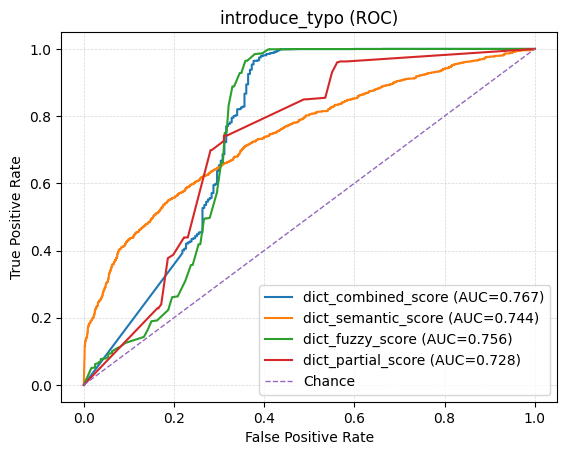

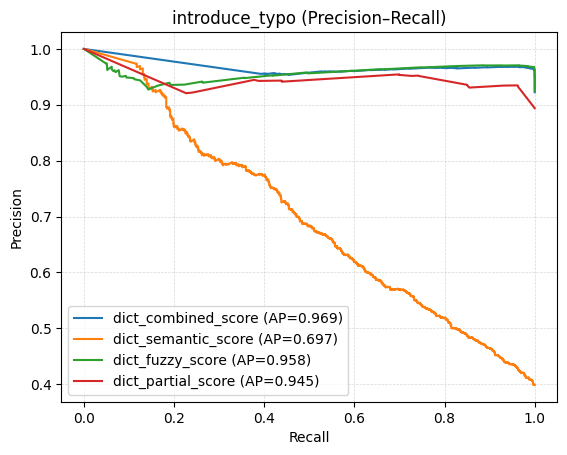

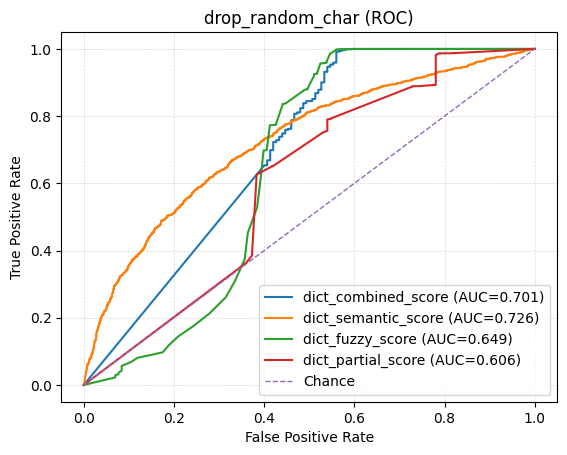

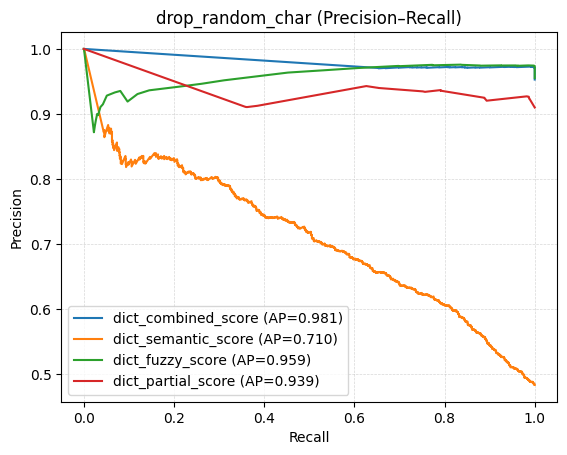

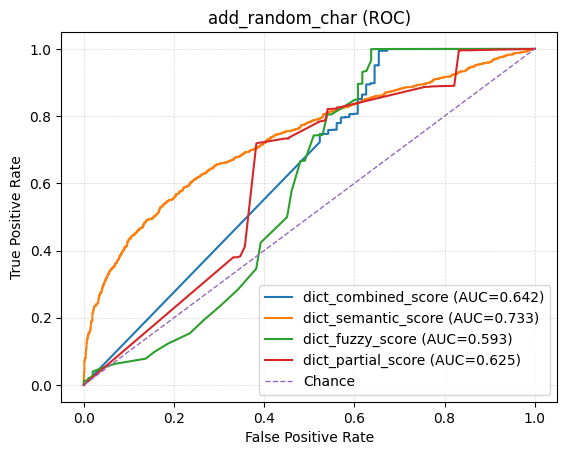

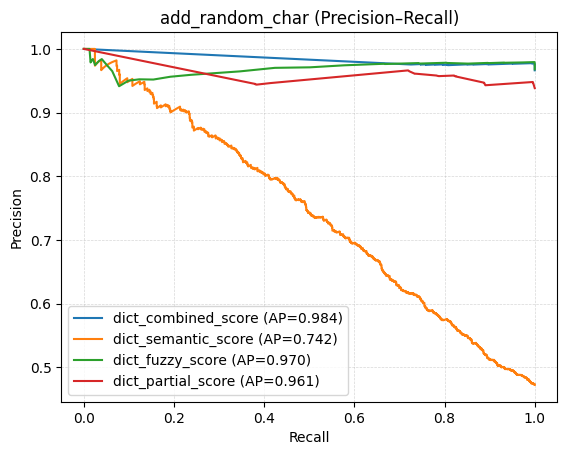

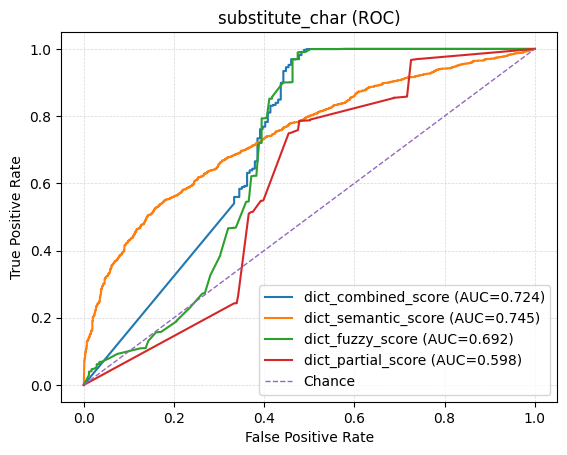

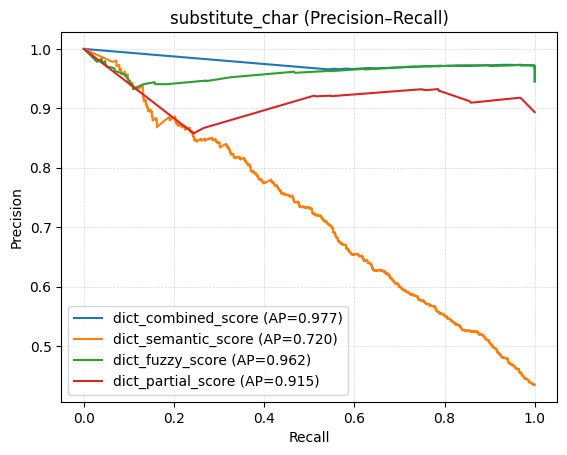

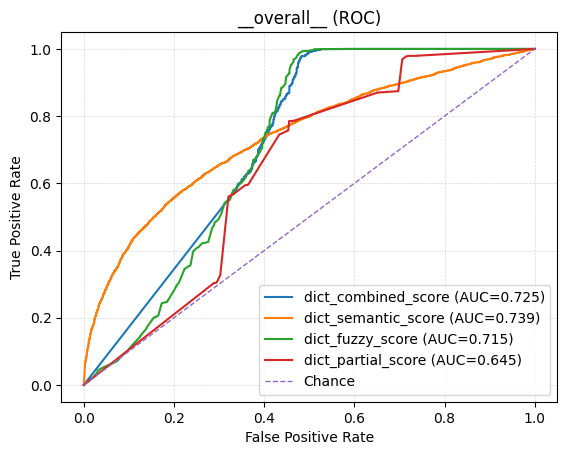

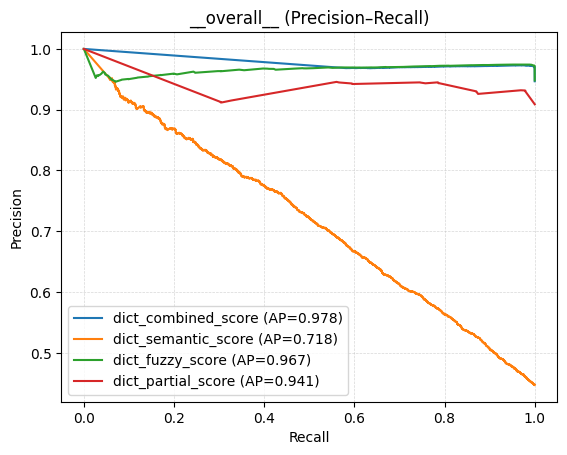

({'dict_combined_score': {'introduce_typo': {'n': 3184,
    'accuracy': 0.9224246231155779,
    'error_rate': 0.07757537688442206,
    'brier': 0.04928207208256405,
    'ece_10bin': 0.0431709496330602,
    'roc_auc': 0.7671644342253445,
    'pr_auc': 0.9685060702505015,
    'mean_conf_all': 0.9449274712811504,
    'mean_conf_correct': 0.9621952032083547,
    'mean_conf_wrong': 0.7396022539928965},
   'drop_random_char': {'n': 3184,
    'accuracy': 0.9528894472361809,
    'error_rate': 0.04711055276381915,
    'brier': 0.034214105294326475,
    'ece_10bin': 0.027110429448725056,
    'roc_auc': 0.7006405185673479,
    'pr_auc': 0.9805897131780651,
    'mean_conf_all': 0.9733624742388576,
    'mean_conf_correct': 0.9817976378953728,
    'mean_conf_wrong': 0.8027472306797482},
   'add_random_char': {'n': 3184,
    'accuracy': 0.9663944723618091,
    'error_rate': 0.03360552763819091,
    'brier': 0.02757015885078198,
    'ece_10bin': 0.018413089829337956,
    'roc_auc': 0.6417890954595294,

In [14]:
results_with_plots(dict_evaluator)

Results Evaluation Metrics
==========dict_combined_score==========
test   | n      | accuracy | error_rate | roc_auc | pr_auc | brier  | ece_10bin | mean_conf_all | mean_conf_correct | mean_conf_wrong
-------+--------+----------+------------+---------+--------+--------+-----------+---------------+-------------------+----------------
introduce_typo | 3184   | 0.9221   | 0.0779     | 0.7554  | 0.9579 | 0.0599 | 0.0782    | 0.8869        | 0.8967            | 0.7714         
drop_random_char | 3184   | 0.9425   | 0.0575     | 0.6608  | 0.9541 | 0.0483 | 0.0516    | 0.9115        | 0.9170            | 0.8209         
add_random_char | 3184   | 0.9604   | 0.0396     | 0.6672  | 0.9728 | 0.0361 | 0.0563    | 0.9178        | 0.9210            | 0.8405         
substitute_char | 3184   | 0.9419   | 0.0581     | 0.7166  | 0.9632 | 0.0461 | 0.0730    | 0.9003        | 0.9082            | 0.7734         
__overall__ | 12736  | 0.9417   | 0.0583     | 0.7097  | 0.9622 | 0.0476 | 0.0648    | 0.9041

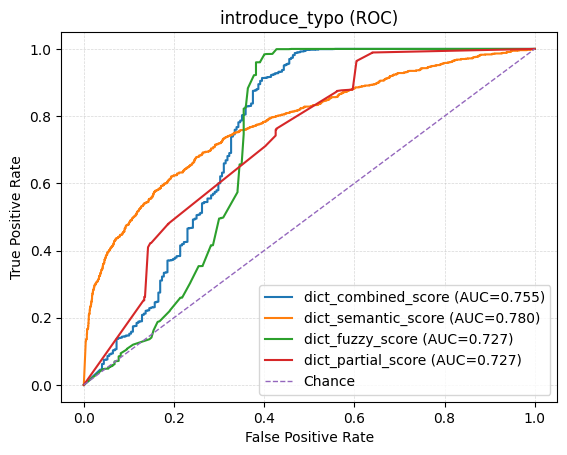

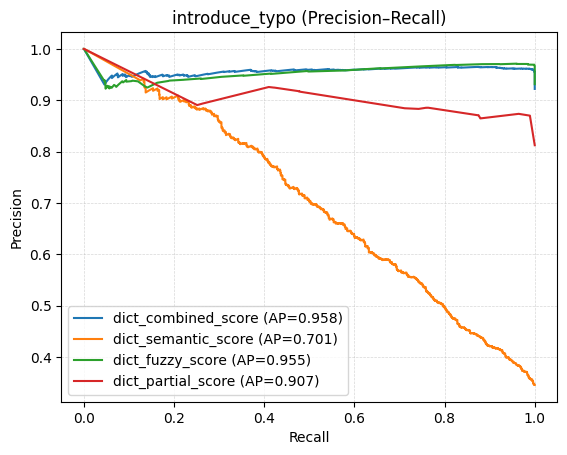

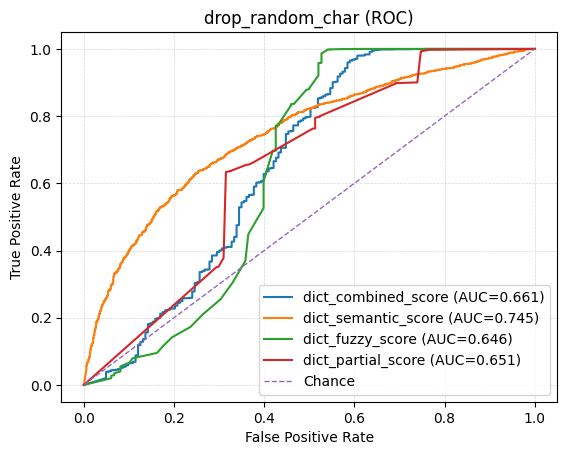

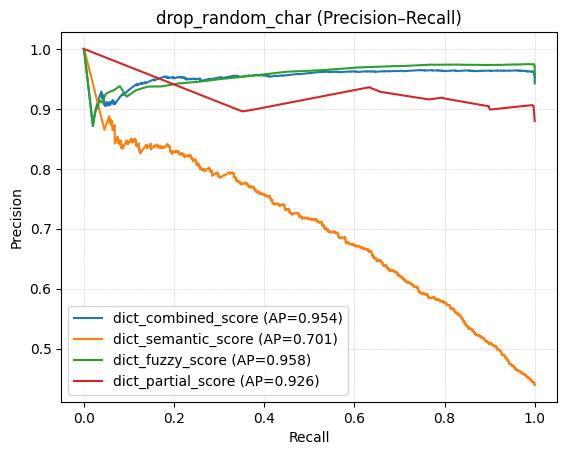

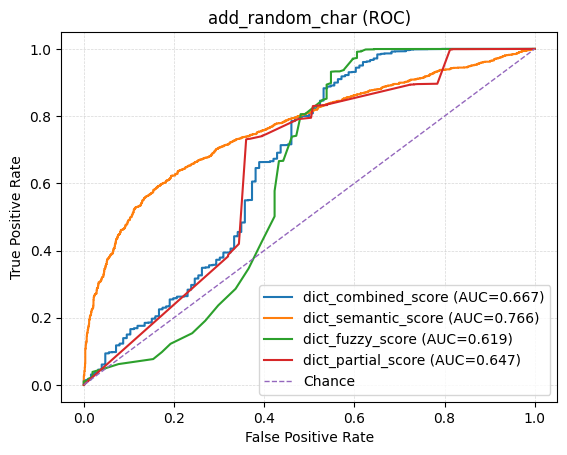

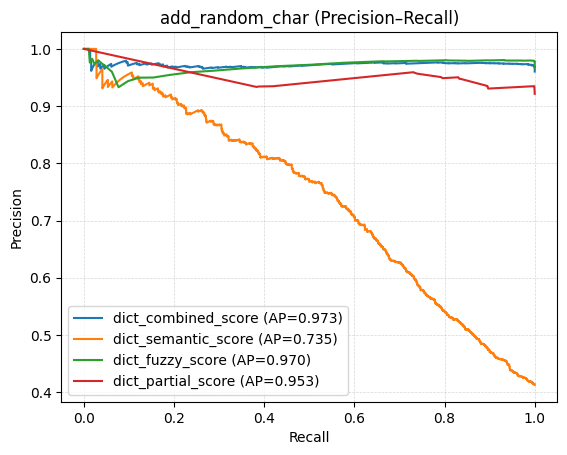

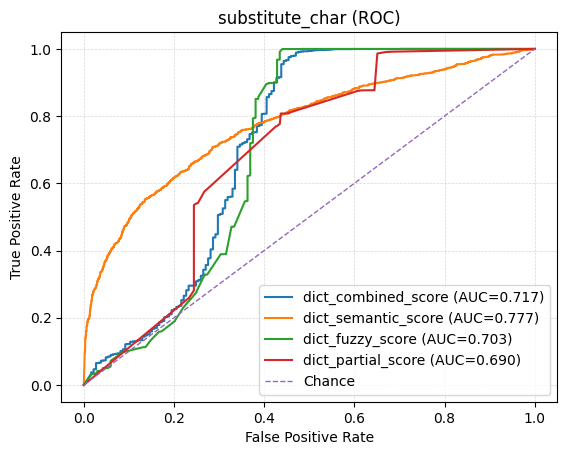

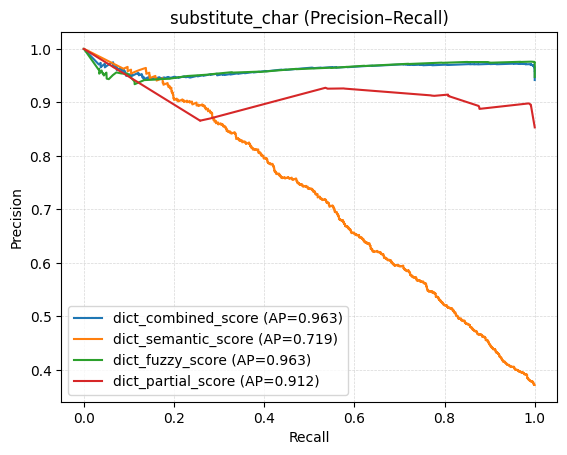

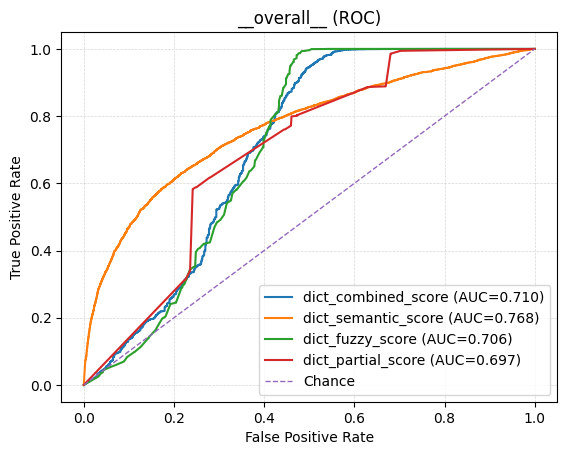

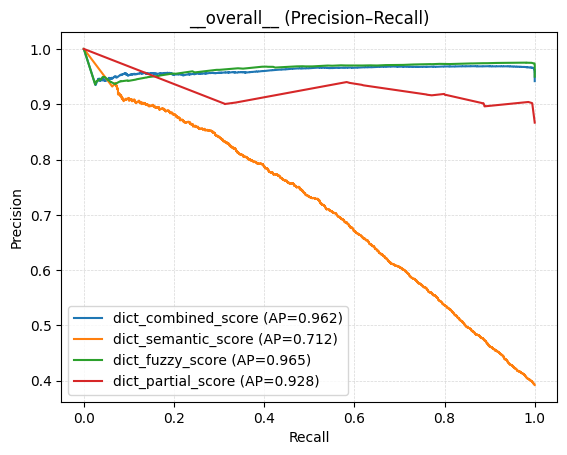

({'dict_combined_score': {'introduce_typo': {'n': 3184,
    'accuracy': 0.9221105527638191,
    'error_rate': 0.07788944723618085,
    'brier': 0.05989935204272028,
    'ece_10bin': 0.07822711597285677,
    'roc_auc': 0.7553692482640412,
    'pr_auc': 0.957867759406336,
    'mean_conf_all': 0.8869024403580469,
    'mean_conf_correct': 0.896662918703595,
    'mean_conf_wrong': 0.7713509709123643},
   'drop_random_char': {'n': 3184,
    'accuracy': 0.9425251256281407,
    'error_rate': 0.057474874371859275,
    'brier': 0.048305942999164346,
    'ece_10bin': 0.05161731856776844,
    'roc_auc': 0.6608270831398644,
    'pr_auc': 0.9540910006427852,
    'mean_conf_all': 0.9114804861496142,
    'mean_conf_correct': 0.9170019196613913,
    'mean_conf_wrong': 0.8209350109100342},
   'add_random_char': {'n': 3184,
    'accuracy': 0.960427135678392,
    'error_rate': 0.039572864321608,
    'brier': 0.036080053540251567,
    'ece_10bin': 0.05627967079343205,
    'roc_auc': 0.6671857319339333,
   

In [39]:
results_with_plots(dict_evaluator)

In [28]:
import numpy as np
evaluation_categories = ['introduce_typo', 'drop_random_char', 'add_random_char', 'substitute_char']
def bootstrap_eval(ingredients, B=100, per_cat=2, seed=42):

    rng_master = np.random.default_rng(seed)
    metrics = {cat: [] for cat in ['introduce_typo','drop_random_char','add_random_char','substitute_char']}
    metrics['overall'] = []
    tests = []
    for b in tqdm(range(B), desc="Bootstrapping"):
        introduce_typo_ls = []
        drop_random_char_ls = []
        add_random_char_ls = []
        substitute_char_ls = []
        rng = np.random.default_rng(rng_master.integers(1<<31))
        # Cluster: ziehe Zutaten mit Zurücklegen
        sample_frac = 0.1  # z.B. 20%
        sampled_ings = rng.choice(ingredients, size=int(sample_frac * len(ingredients)), replace=True)
        # baue Testset (z.B. per_cat Typos je Fehlerart/Zutat)
        for ing in sampled_ings:
            for _ in range(per_cat):
                introduce_typo_ls.append([ing, introduce_typo(ing)])
                drop_random_char_ls.append([ing, drop_random_char(ing)])
                add_random_char_ls.append([ing, add_random_char(ing)])
                substitute_char_ls.append([ing, substitute_char(ing)])
            tests.append({
        'introduce_typo':introduce_typo_ls,
        'drop_random_char': drop_random_char_ls,
        'add_random_char': add_random_char_ls,
        'substitute_char': substitute_char_ls
    }  )
    return tests

In [27]:
bootstrat_dataset = bootstrap_eval(english_terms)

Bootstrapping: 100%|██████████| 100/100 [00:00<00:00, 385.63it/s]


In [ ]:
def results_with_plots(dict_evaluator: List[Dict[str, List[Record]]],
                       groups=("introduce_typo","drop_random_char","add_random_char",
                               "substitute_char","__overall__")):
    """
    dict_evaluator: { approach_name: { test_name: List[Record], ... }, ... }
    Gibt pro Approach die Metriktabelle aus UND speichert ROC/PR-PNGs je group.
    """
    all_metrics = {}
    all_payload = {}

    print("Results Evaluation Metrics")
    for dataset in dict_evaluator:
        metrics, payload = evaluate_method_with_curves(dataset)
        pretty_print(metrics)
        print("="*30)

        all_metrics.append(metrics)
        all_payload.append(payload)

    # Plots über Ansätze hinweg je Gruppe
    for g in groups:
        plot_roc_from_payload(all_payload, group=g, out_path=f"roc_{g}.png")
        plot_pr_from_payload(all_payload,  group=g, out_path=f"pr_{g}.png")

    return all_metrics, all_payload
